In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import backtest

In [2]:
# TODO: move to separate module
n = 1000
base_price = 1
norm_gen = np.random.default_rng(seed=33)
returns = norm_gen.normal(size=n, loc=0, scale=0.001)
prices = base_price * np.exp(np.cumsum(np.log(returns + 1)))
times = pd.date_range('2025-01-01 06:00:00', periods=n, freq='min')
price_df = pd.DataFrame({'t': times, 'price': prices})
signal_df = pd.DataFrame({'t': times, 'signal': norm_gen.choice([-1, 0, 1], p=[0.1, 0.8, 0.1], size=n)})

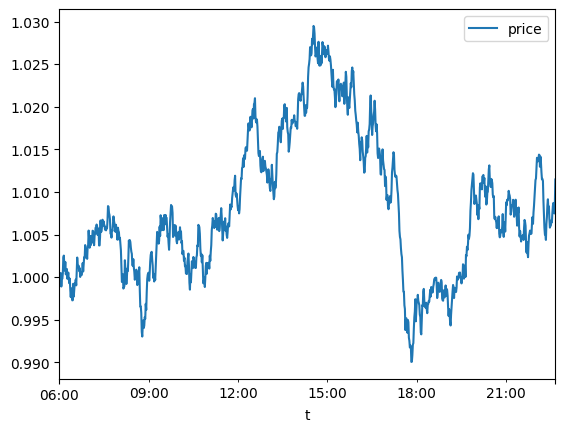

In [3]:
price_df.plot(x='t', y='price')
plt.show()

### Extreme spread case

In [4]:
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=0.02)

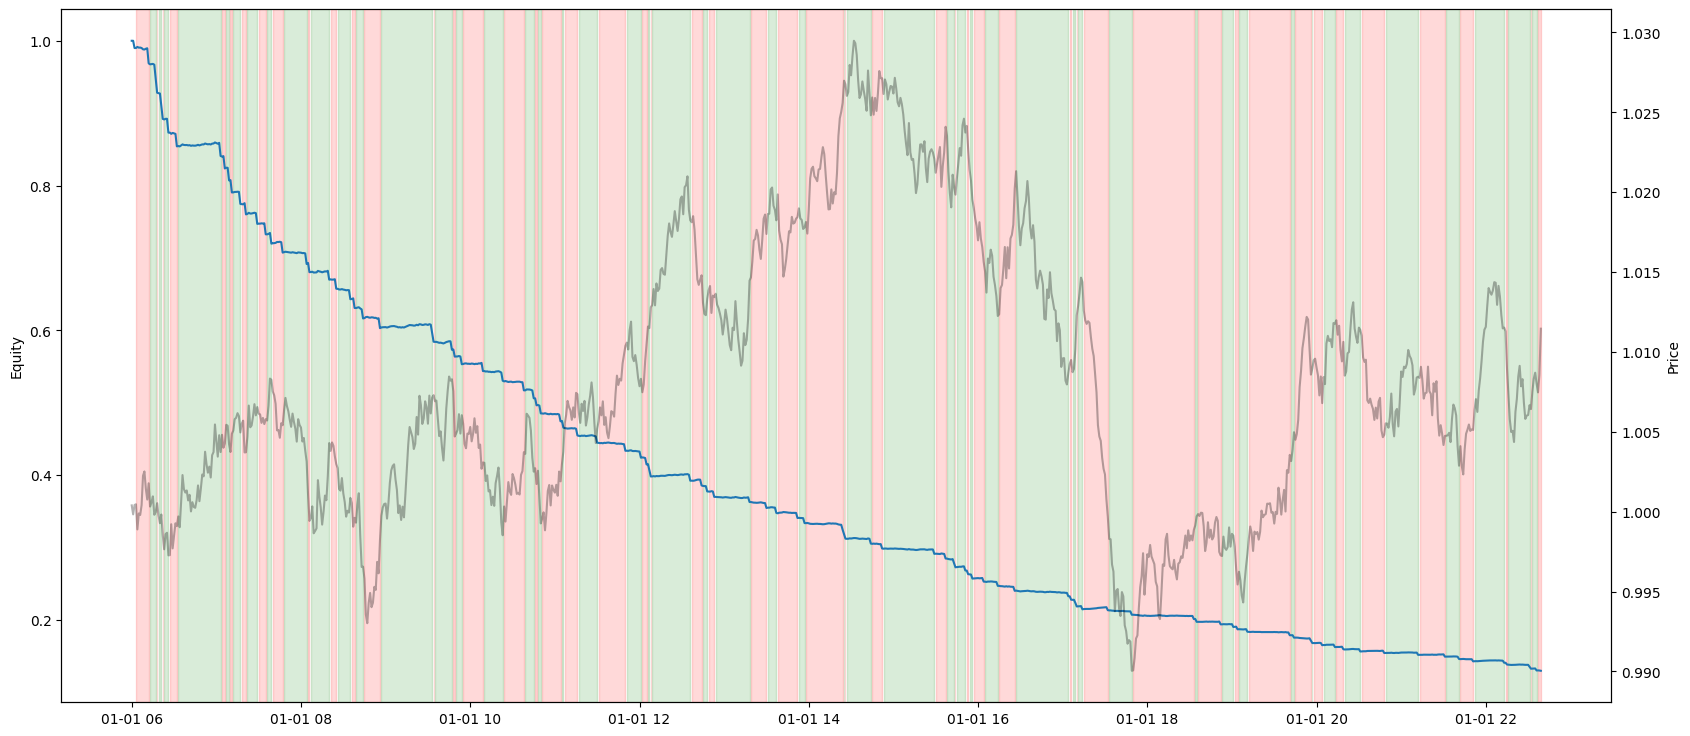

In [5]:
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()

In [6]:
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=0.0002)

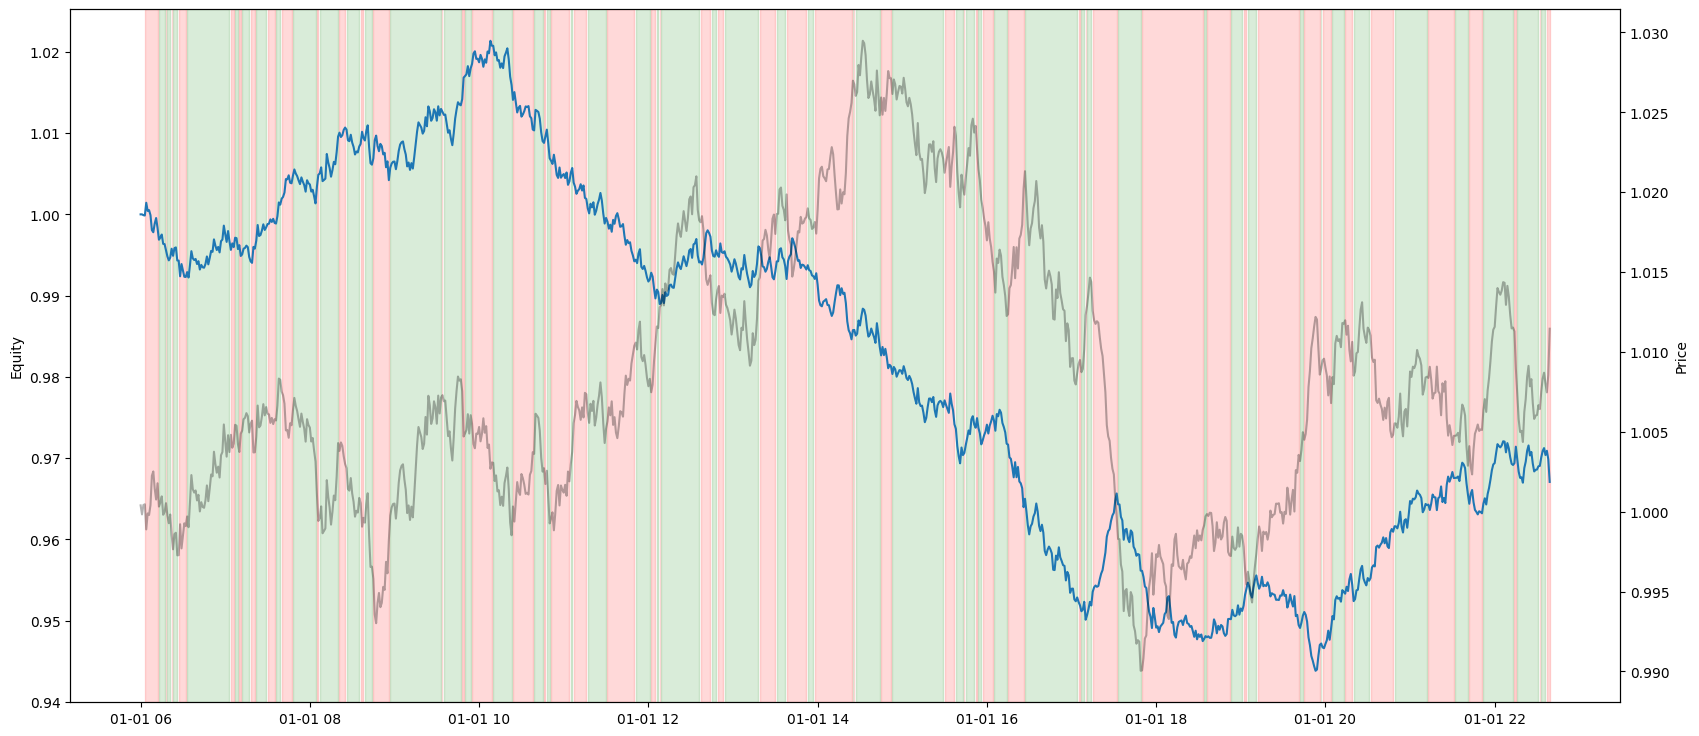

In [7]:
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()

In [8]:
spread_df = pd.DataFrame({'t': times, 'quoted_spread': 0.0002 * np.exp(norm_gen.normal(loc=0, scale=2, size=n))})
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=spread_df)

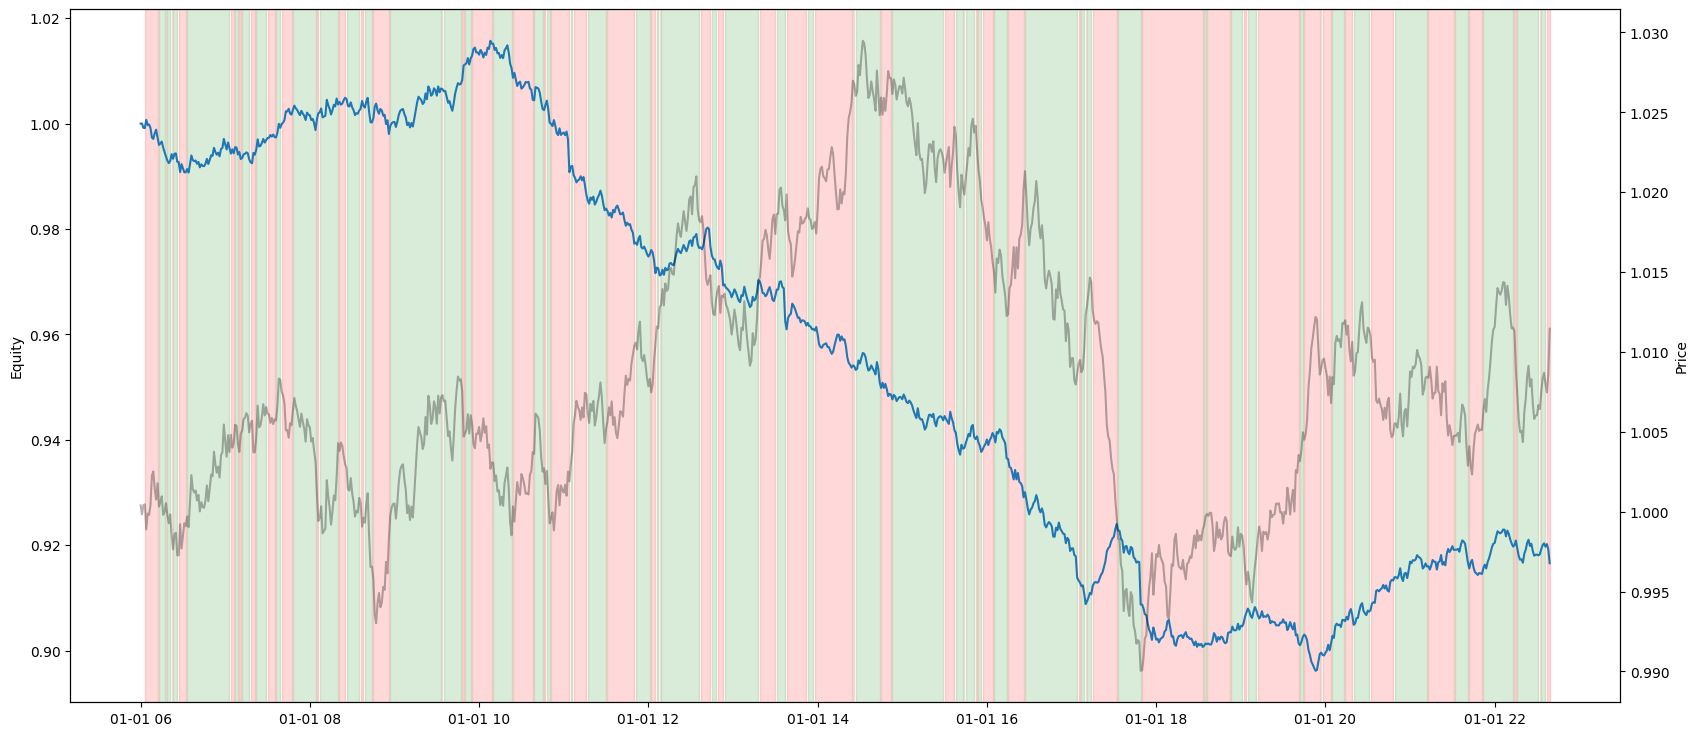

In [9]:
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()

In [10]:
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=0)

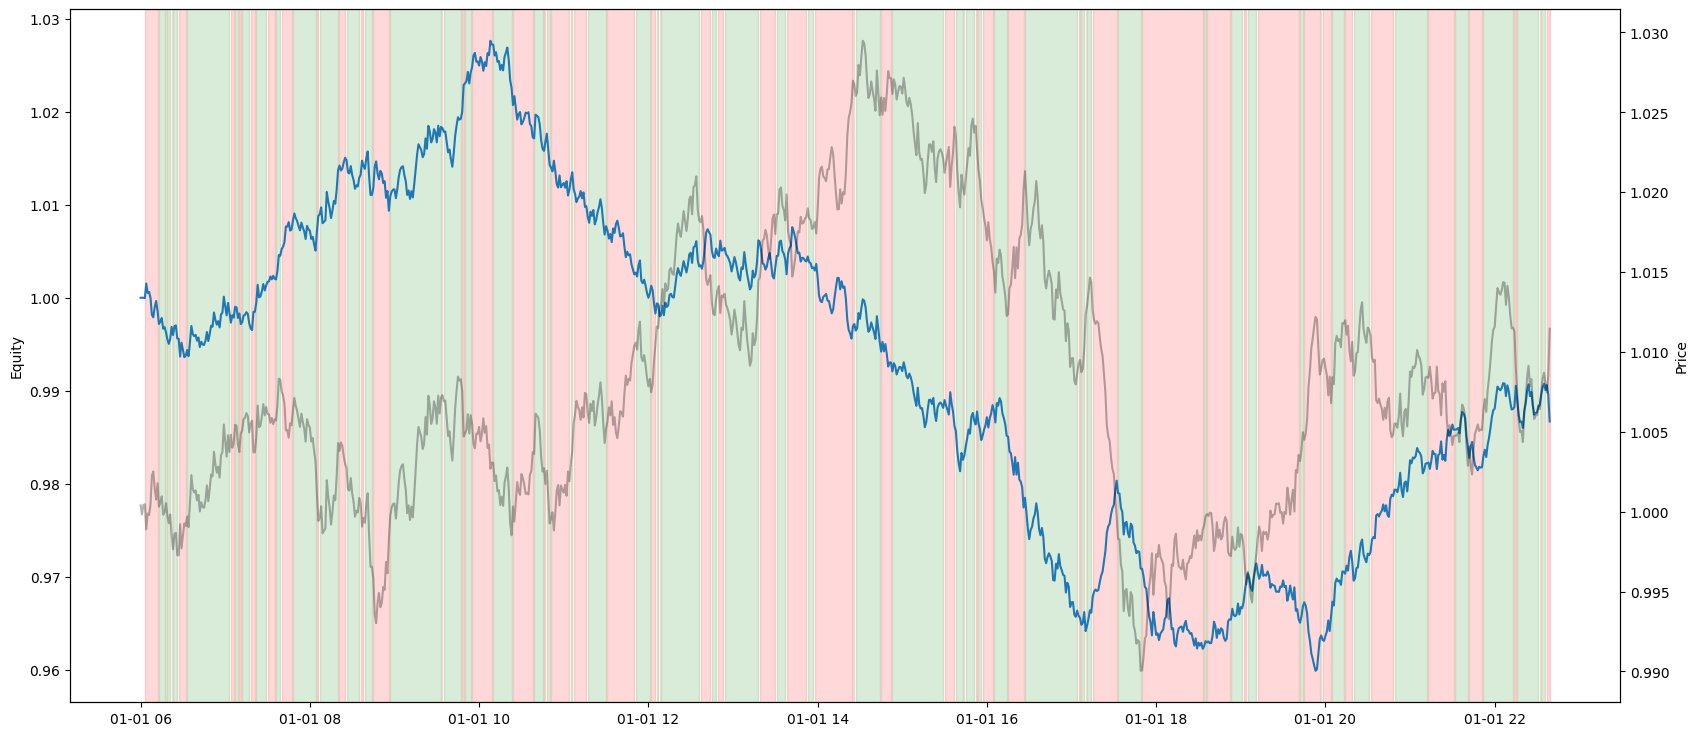

In [11]:
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()

## Absolute spread example

In [12]:
# TODO: move to separate module
n = 1000
base_price = 100
norm_gen = np.random.default_rng(seed=32)
returns = norm_gen.normal(size=n, loc=0, scale=0.001)
prices = base_price * np.exp(np.cumsum(np.log(returns + 1)))
times = pd.date_range('2025-01-01 06:00:00', periods=n, freq='min')
price_df = pd.DataFrame({'t': times, 'price': prices})
signal_df = pd.DataFrame({'t': times, 'signal': norm_gen.choice([-1, 0, 1], p=[0.1, 0.8, 0.1], size=n)})

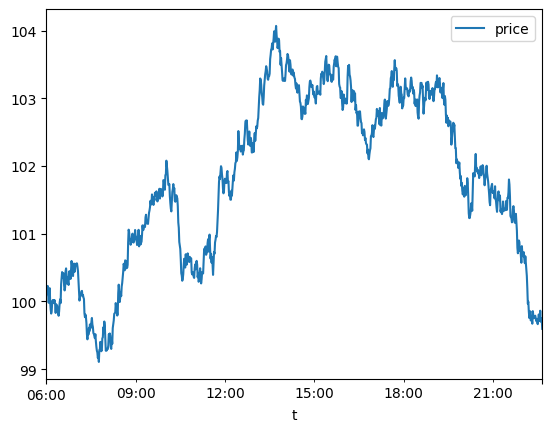

In [13]:
price_df.plot(x='t', y='price')
plt.show()

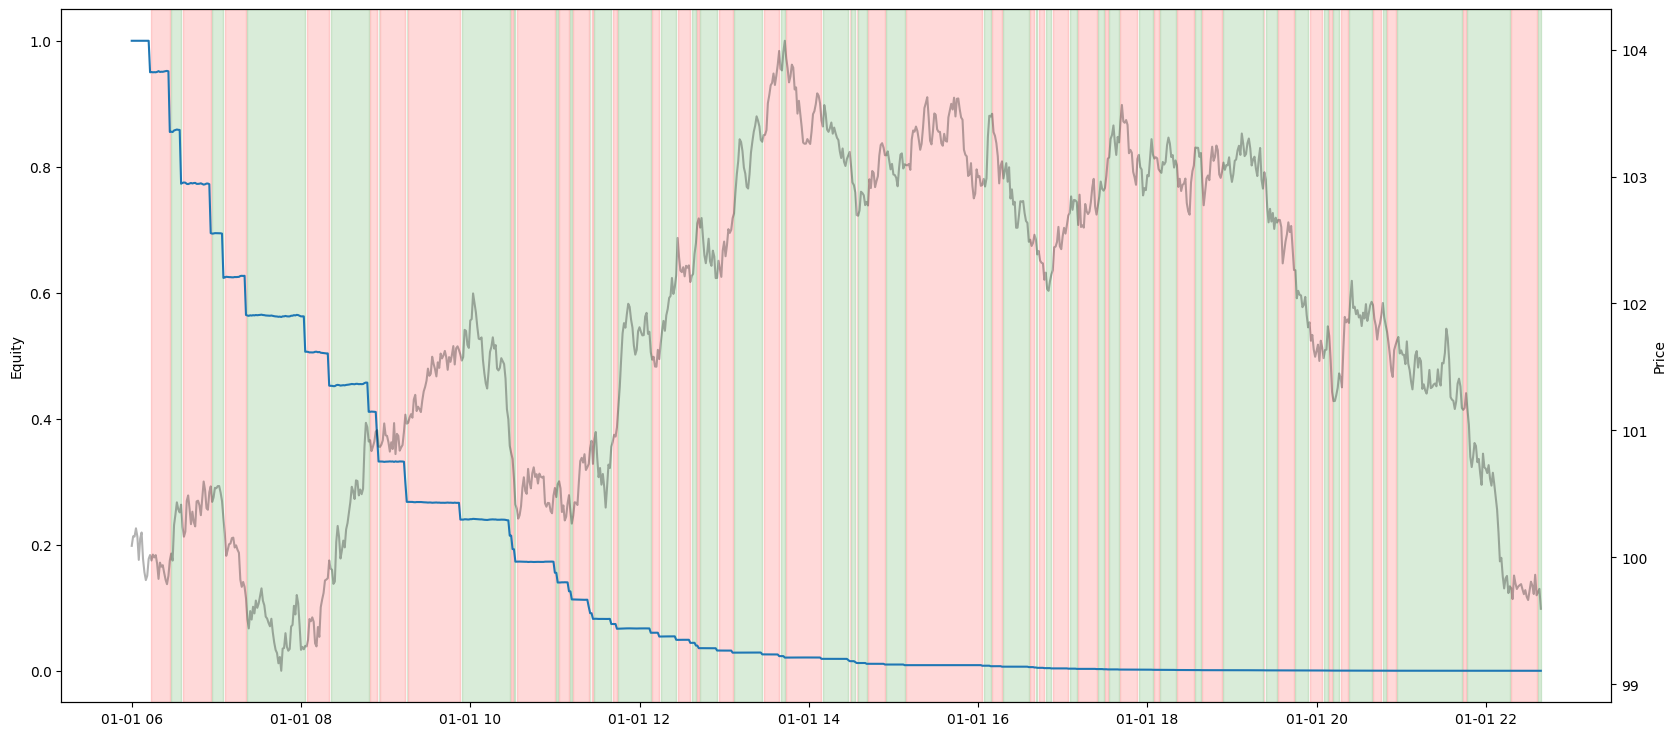

In [14]:
# Forget to put off relative spread flag
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=0.1)
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()

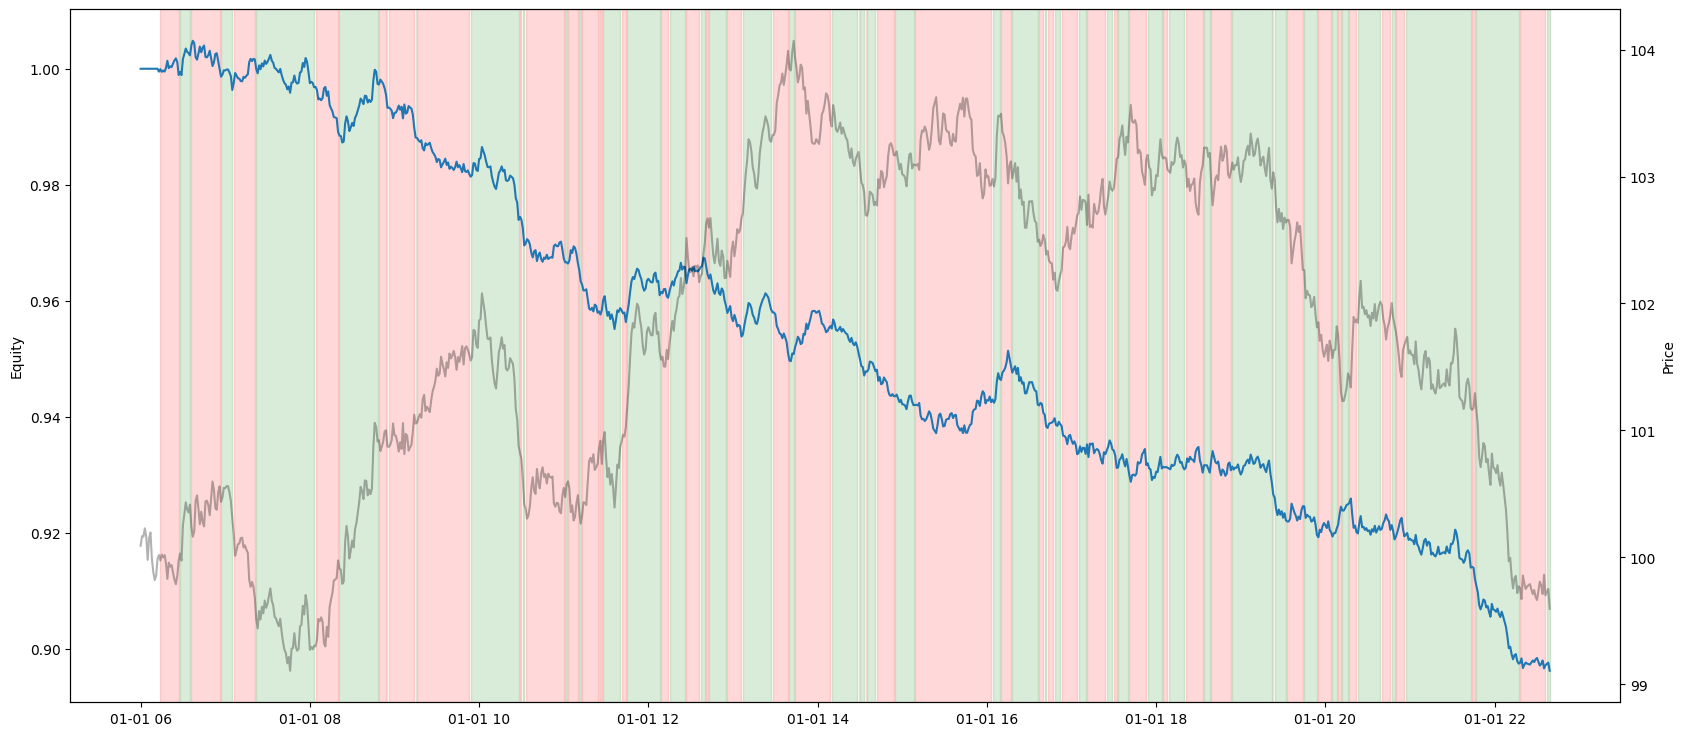

In [15]:
# Relative spread
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=0.1, spread_is_relative=False)
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()

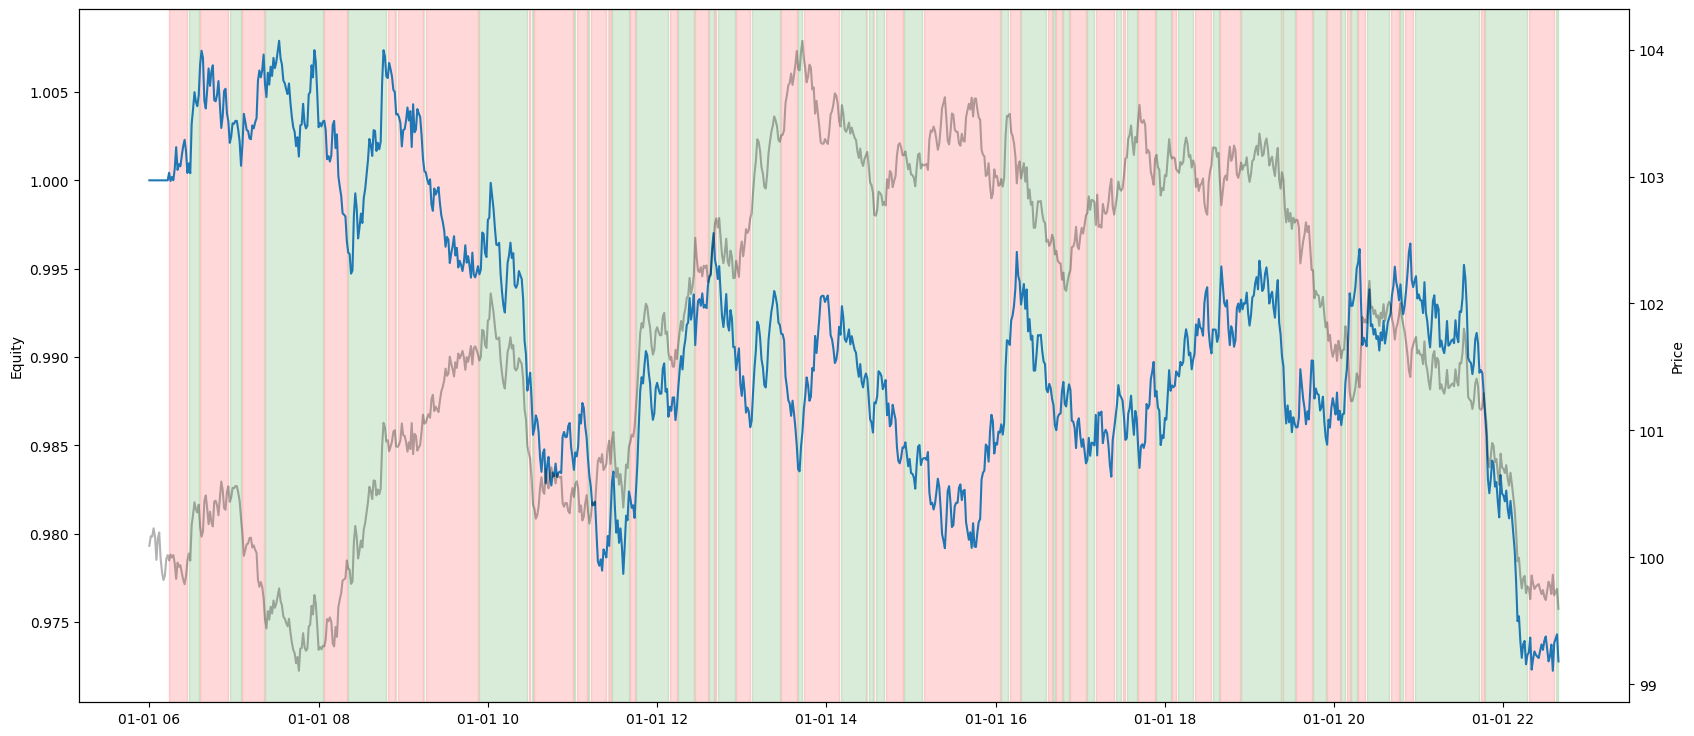

In [16]:
# No spread at all for reference
return_df, trade_df = backtest.backtester(price_df, signal_df, spread=0)
# TODO: move to separate module
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(return_df['t'], return_df['equity'])
ymin, ymax = ax.get_ylim()
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] > 0), color='green', alpha=0.15)
ax.fill_between(return_df['t'], ymin, ymax, where=(return_df['r_position'] < 0), color='red', alpha=0.15)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Equity')

ax2 = ax.twinx()
ax2.plot(price_df['t'], price_df['price'], c='black', alpha=0.3)
ax2.set_ylabel('Price')
plt.show()